Files already downloaded and verified
Epoch  1 | Std D=1.573, G=3.195 | CVaR D=1.502, G=5.807
Epoch  2 | Std D=1.608, G=1.641 | CVaR D=1.497, G=2.984
Epoch  3 | Std D=1.549, G=1.507 | CVaR D=1.344, G=3.033
Epoch  4 | Std D=1.477, G=1.367 | CVaR D=1.403, G=2.641
Epoch  5 | Std D=1.460, G=1.405 | CVaR D=1.359, G=2.595
Epoch  6 | Std D=1.472, G=1.255 | CVaR D=1.293, G=2.606
Epoch  7 | Std D=1.452, G=1.253 | CVaR D=1.350, G=2.469
Epoch  8 | Std D=1.376, G=1.242 | CVaR D=1.234, G=2.540
Epoch  9 | Std D=1.388, G=1.137 | CVaR D=1.273, G=2.529
Epoch 10 | Std D=1.389, G=1.192 | CVaR D=1.269, G=2.394
Epoch 11 | Std D=1.354, G=1.110 | CVaR D=1.269, G=2.387
Epoch 12 | Std D=1.343, G=1.126 | CVaR D=1.280, G=2.378
Epoch 13 | Std D=1.328, G=1.137 | CVaR D=1.244, G=2.330
Epoch 14 | Std D=1.334, G=1.137 | CVaR D=1.219, G=2.494
Epoch 15 | Std D=1.290, G=1.201 | CVaR D=1.237, G=2.395
Epoch 16 | Std D=1.253, G=1.203 | CVaR D=1.231, G=2.402
Epoch 17 | Std D=1.257, G=1.174 | CVaR D=1.200, G=2.397
Epoch 18 |

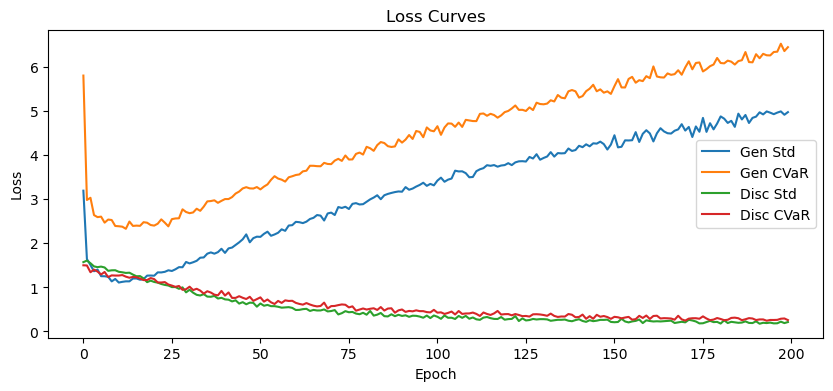

Latent rob Std/CVaR: 0.0195 0.018800000000000004
Tail fit Std: {'threshold': 1.4767023801803603, 'shape': -0.070405706394698, 'scale': 1.0973418420414962}
Tail fit CVaR: {'threshold': 1.2216320991516123, 'shape': -0.06748344951968471, 'scale': 1.3535693290346376}


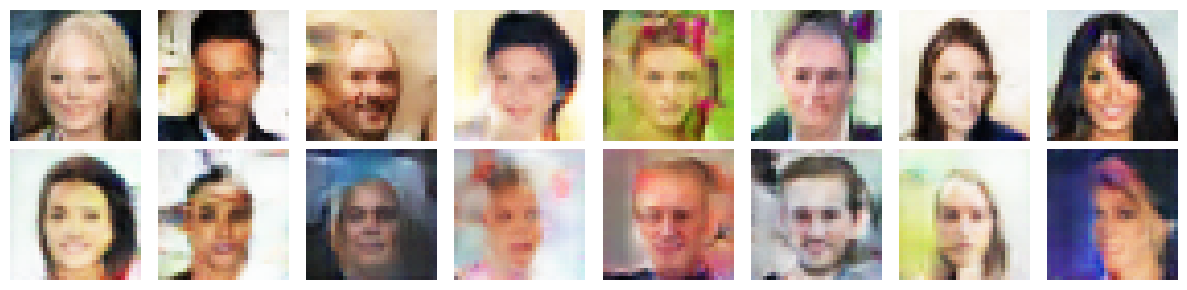

Std GAN   → 90th% = 1.840, CVaR = 2.942
CVaR GAN  → 90th% = 1.495, CVaR = 2.872


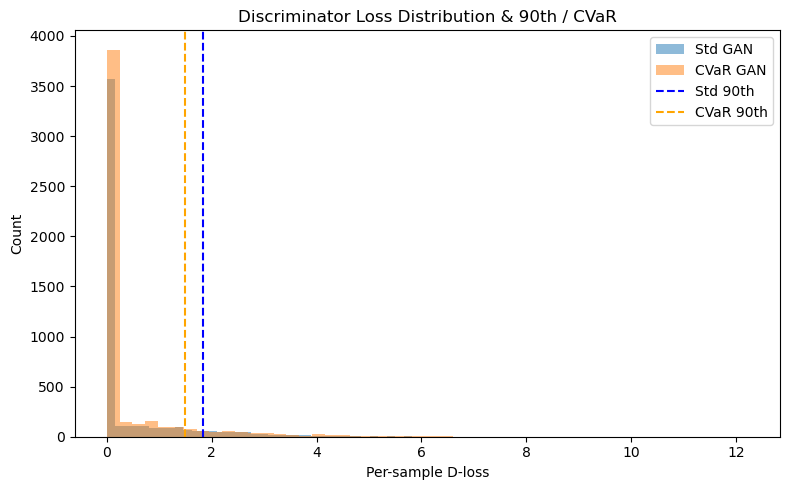

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import torch
import numpy as np
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision import transforms
from scipy.linalg import sqrtm
from scipy.stats import genpareto
from sklearn.neighbors import NearestNeighbors

# ---------- Inception feature extractor for FID ----------
class InceptionV3Feature(torch.nn.Module):
    def __init__(self):
        super().__init__()
        inc = inception_v3(pretrained=True, aux_logits=False, transform_input=False)
        inc.fc = torch.nn.Identity()
        self.model = inc.eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, x):
        # x in [-1,1], shape [B,3,H,W]
        return self.model(x)

# ---------- Helpers for FID ----------
def calculate_activation_stats(feats):
    mu = np.mean(feats, axis=0)
    sigma = np.cov(feats, rowvar=False)
    return mu, sigma

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        sigma1 += np.eye(sigma1.shape[0]) * eps
        sigma2 += np.eye(sigma2.shape[0]) * eps
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    covmean = np.real(covmean)
    return np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2*covmean)

# ---------- 5. Worst‐Case FID Across Subpopulations ----------
def worst_group_fid(G, real_loader, attr_indices, device, batches=10, max_real=500):
    feat_extractor = InceptionV3Feature().to(device)
    resize = transforms.Resize((299,299))
    latent_dim = G.net[0].in_channels
    worst = 0.0

    for idx in attr_indices:
        # collect real features for this group
        real_feats = []
        with torch.no_grad():
            for imgs, attrs in real_loader:
                mask = attrs[:, idx].bool()
                if mask.any():
                    x = imgs[mask].to(device)
                    x = resize(x)
                    real_feats.append(feat_extractor(x).cpu().numpy())
                if len(real_feats)*real_loader.batch_size >= max_real:
                    break
        real_feats = np.vstack(real_feats)[:max_real]
        mu_r, sigma_r = calculate_activation_stats(real_feats)

        # collect fake features
        fake_feats = []
        with torch.no_grad():
            for _ in range(batches):
                z = torch.randn(real_loader.batch_size, latent_dim, device=device)
                fake = G(z)
                fake = resize(fake)
                fake_feats.append(feat_extractor(fake).cpu().numpy())
        fake_feats = np.vstack(fake_feats)
        mu_f, sigma_f = calculate_activation_stats(fake_feats)

        fid_score = frechet_distance(mu_r, sigma_r, mu_f, sigma_f)
        worst = max(worst, fid_score)

    return worst

# ---------- 7. Mode Dropping / Coverage of attribute combinations ----------
def mode_coverage(G, classifier, real_loader, device, total_samples=10000):
    # real combos
    real_set = set()
    for _, attrs in real_loader:
        for row in attrs.cpu().numpy().astype(int):
            real_set.add(tuple(row))
    # fake combos
    fake_set = set()
    latent_dim = G.net[0].in_channels
    with torch.no_grad():
        for _ in range(total_samples // real_loader.batch_size):
            z = torch.randn(real_loader.batch_size, latent_dim, device=device)
            fake = G(z)
            preds = (classifier(fake).sigmoid() > 0.5).cpu().numpy().astype(int)
            for row in preds:
                fake_set.add(tuple(row))
    coverage = len(fake_set & real_set) / len(real_set)
    return coverage, len(real_set), len(fake_set)

# ---------- 8. Latent Space Robustness ----------
def latent_robustness(G, D, device, num_samples=100, eps_init=0.01, step=0.01, threshold=0.0):
    robs = []
    latent_dim = G.net[0].in_channels
    for _ in range(num_samples):
        z = torch.randn(1, latent_dim, device=device)
        orig = D(G(z)).item()
        eps = eps_init
        while True:
            z_pert = z + eps * torch.randn_like(z)
            score = D(G(z_pert)).item()
            if score < orig - threshold or eps > 10:
                robs.append(eps)
                break
            eps += step
    return float(np.mean(robs))

# ---------- 10. Extreme Value Statistics (GPD fit) ----------
def fit_tail_distribution(losses, quantile=0.9):
    threshold = np.quantile(losses, quantile)
    tail = losses[losses > threshold] - threshold
    c, loc, scale = genpareto.fit(tail, floc=0)
    return {"threshold": float(threshold), "shape": float(c), "scale": float(scale)}


# -----------------------------------------------------------------------------
# CONFIGURE FAST CUDNN
# -----------------------------------------------------------------------------
torch.backends.cudnn.benchmark = True

# -----------------------------------------------------------------------------
# FAST CVaR: use topk instead of full sort
# -----------------------------------------------------------------------------
def cvar_topk(losses: torch.Tensor, alpha: float) -> torch.Tensor:
    k = max(1, int((1 - alpha) * losses.numel()))
    topk_vals, _ = losses.topk(k, largest=True)
    return topk_vals.mean()

# -----------------------------------------------------------------------------
# SMALLER DCGAN FOR 32×32 IMAGES
# -----------------------------------------------------------------------------
class Generator32(nn.Module):
    def __init__(self, latent_dim=100, base_ch=128, channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, base_ch * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_ch * 2), nn.ReLU(True),
            nn.ConvTranspose2d(base_ch * 2, base_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_ch), nn.ReLU(True),
            nn.ConvTranspose2d(base_ch, base_ch//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_ch//2), nn.ReLU(True),
            nn.ConvTranspose2d(base_ch//2, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))

class Discriminator32(nn.Module):
    def __init__(self, base_ch=128, channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, base_ch//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch//2, base_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_ch), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch, base_ch * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_ch * 2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch * 2, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.net(x).view(-1)

# -----------------------------------------------------------------------------
# SINGLE EPOCH TRAINING (CVaR on BOTH D and G when alpha is set)
# -----------------------------------------------------------------------------
def train_epoch(G, D, loader, optG, optD, device, alpha=None):
    relu = nn.ReLU()
    G.train(); D.train()
    d_sum = g_sum = 0.0
    count = 0
    for real, _ in loader:
        real = real.to(device, non_blocking=True)
        bs = real.size(0)

        # Discriminator step
        optD.zero_grad()
        real_scores = D(real)
        z = torch.randn(bs, G.net[0].in_channels, device=device)
        fake = G(z).detach()
        fake_scores = D(fake)
        d_per = relu(1 - real_scores) + relu(1 + fake_scores)
        d_loss = d_per.mean() if alpha is None else cvar_topk(d_per, alpha)
        d_loss.backward()
        optD.step()

        # Generator step
        optG.zero_grad()
        z = torch.randn(bs, G.net[0].in_channels, device=device)
        synth = G(z)
        scores = D(synth)
        g_per = -scores
        g_loss = g_per.mean() if alpha is None else cvar_topk(g_per, alpha)
        g_loss.backward()
        optG.step()

        d_sum += d_loss.item()
        g_sum += g_loss.item()
        count += 1

    return d_sum/count, g_sum/count

# -----------------------------------------------------------------------------
# MAIN: FAST GAN vs CVaR-GAN on 32×32 CelebA subset + metrics plotting
# -----------------------------------------------------------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparams
    epochs = 200
    batch_size = 16
    lr = 2e-3
    alpha = 0.3
    subset_size = 5000
    latent_dim = 100

    # Data loader: 32×32 crop, parallel I/O
    transform = transforms.Compose([
        transforms.CenterCrop(178),
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3),
    ])
    celeba = datasets.CelebA("/Users/jingfutan/Documents/GitHub/DSCI-498-Course-Project/celeba_data",
                             split="train", download=True, transform=transform)
    indices = torch.randperm(len(celeba))[:subset_size]
    celeba_sub = Subset(celeba, indices)
    loader = DataLoader(
        celeba_sub,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )

    # Models
    G_std   = Generator32().to(device)
    D_std   = Discriminator32().to(device)
    G_cvar  = Generator32().to(device)
    D_cvar  = Discriminator32().to(device)

    # PyTorch 2.0 compile (optional)
    if hasattr(torch, "compile"):
        G_std  = torch.compile(G_std)
        D_std  = torch.compile(D_std)
        G_cvar = torch.compile(G_cvar)
        D_cvar = torch.compile(D_cvar)

    # Optimizers
    optG_std  = optim.Adam(G_std.parameters(),  lr=lr, betas=(0.5,0.999))
    optD_std  = optim.Adam(D_std.parameters(),  lr=lr, betas=(0.5,0.999))
    optG_cvar = optim.Adam(G_cvar.parameters(), lr=lr, betas=(0.5,0.999))
    optD_cvar = optim.Adam(D_cvar.parameters(), lr=lr, betas=(0.5,0.999))

    # Train and record
    losses_std  = {"d": [], "g": []}
    losses_cvar = {"d": [], "g": []}
    for ep in range(1, epochs+1):
        ds, gs = train_epoch(G_std,  D_std,  loader, optG_std,  optD_std,  device, alpha=None)
        dc, gc = train_epoch(G_cvar, D_cvar, loader, optG_cvar, optD_cvar, device, alpha=alpha)
        losses_std["d"].append(ds);   losses_std["g"].append(gs)
        losses_cvar["d"].append(dc);  losses_cvar["g"].append(gc)
        print(f"Epoch {ep:2d} | Std D={ds:.3f}, G={gs:.3f} | CVaR D={dc:.3f}, G={gc:.3f}")

    # Plot loss curves
    plt.figure(figsize=(10,4))
    plt.plot(losses_std["g"], label="Gen Std")
    plt.plot(losses_cvar["g"], label="Gen CVaR")
    plt.plot(losses_std["d"], label="Disc Std")
    plt.plot(losses_cvar["d"], label="Disc CVaR")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curves")
    plt.show()

    # Collect per-sample d-loss arrays
    d_std_arr, d_cvar_arr = [], []
    with torch.no_grad():
        for real, _ in loader:
            real = real.to(device)
            bs   = real.size(0)
            rs = D_std(real); fs = D_std(G_std(torch.randn(bs,latent_dim,device=device)))
            d_std_arr.append(F.relu(1-rs)+F.relu(1+fs))
            rs2 = D_cvar(real); fs2 = D_cvar(G_cvar(torch.randn(bs,latent_dim,device=device)))
            d_cvar_arr.append(F.relu(1-rs2)+F.relu(1+fs2))
    d_std_arr  = torch.cat(d_std_arr).cpu().numpy()
    d_cvar_arr = torch.cat(d_cvar_arr).cpu().numpy()

    print("Latent rob Std/CVaR:",
          latent_robustness(G_std, D_std, device),
          latent_robustness(G_cvar, D_cvar, device))

    print("Tail fit Std:",  fit_tail_distribution(d_std_arr))
    print("Tail fit CVaR:", fit_tail_distribution(d_cvar_arr))

    # Sample visualization
    G_std.eval(); G_cvar.eval()
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        s_std  = G_std(z).cpu()
        s_cvar = G_cvar(z).cpu()

    fig, axs = plt.subplots(2, 8, figsize=(12,3))
    for i in range(8):
        axs[0,i].imshow((s_std[i].permute(1,2,0)*0.5+0.5).clamp(0,1))
        axs[0,i].axis("off")
        axs[1,i].imshow((s_cvar[i].permute(1,2,0)*0.5+0.5).clamp(0,1))
        axs[1,i].axis("off")
    axs[0,0].set_ylabel("Std GAN", rotation=0, labelpad=30)
    axs[1,0].set_ylabel("CVaR GAN", rotation=0, labelpad=30)
    plt.tight_layout()
    plt.show()

    # ──────────────────────────────────────────────────
    # Plot per-sample D-loss distribution & 90th/CVaR
    # ──────────────────────────────────────────────────
    N = 5000
    d_std_list, d_cvar_list = [], []

    with torch.no_grad():
        for real, _ in loader:
            real = real.to(device)
            bs   = real.size(0)

            rs = D_std(real)
            fs = D_std(G_std(torch.randn(bs, latent_dim, device=device)))
            d_std = F.relu(1 - rs) + F.relu(1 + fs)
            d_std_list.append(d_std.cpu().numpy())

            rs2 = D_cvar(real)
            fs2 = D_cvar(G_cvar(torch.randn(bs, latent_dim, device=device)))
            d_cvar = F.relu(1 - rs2) + F.relu(1 + fs2)
            d_cvar_list.append(d_cvar.cpu().numpy())

            if sum(len(x) for x in d_std_list) >= N:
                break

    d_std_arr  = np.concatenate(d_std_list)[:N]
    d_cvar_arr = np.concatenate(d_cvar_list)[:N]

    q90_std   = np.percentile(d_std_arr,  90)
    q90_cvar  = np.percentile(d_cvar_arr, 90)
    cvar_std  = d_std_arr [d_std_arr  >= q90_std ].mean()
    cvar_cvar = d_cvar_arr[d_cvar_arr >= q90_cvar].mean()

    print(f"Std GAN   → 90th% = {q90_std:.3f}, CVaR = {cvar_std:.3f}")
    print(f"CVaR GAN  → 90th% = {q90_cvar:.3f}, CVaR = {cvar_cvar:.3f}")

    plt.figure(figsize=(8,5))
    plt.hist(d_std_arr,  bins=50, alpha=0.5, label='Std GAN')
    plt.hist(d_cvar_arr, bins=50, alpha=0.5, label='CVaR GAN')
    plt.axvline(q90_std,  color='blue',  linestyle='--', label='Std 90th')
    plt.axvline(q90_cvar, color='orange',linestyle='--', label='CVaR 90th')
    plt.xlabel("Per-sample D-loss")
    plt.ylabel("Count")
    plt.title("Discriminator Loss Distribution & 90th / CVaR")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
